# Лабораторная работа №2 Проведение исследований с логистической и линейной регрессией

## 2. Создание бейзлайн и оценка качества

Возьмём датасеты из прошлой лабораторной и обучим на них новые модели.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics


df_class = pd.read_csv('neo_v2.csv')
df_reg = pd.read_csv('wind_vs_price.csv')

# Столбцы, содержащие названия и имена, не влияют на результат классификации
df_class = df_class.drop(['orbiting_body','sentry_object', 'name', 'id'],axis=1)
df_class = df_class.sort_values('hazardous', ascending=False).head(2*df_class['hazardous'].value_counts().get(True, 0))

# Для регрессии необходимо перевести даты в timestamp и убрать даты после 2019 года, исключив фактор ковидного времени
df_reg = df_reg.drop(df_reg[df_reg.fecha > "2019-01-01"].index)
df_reg['time'] = pd.to_datetime(df_reg['fecha']).astype(int)
df_reg = df_reg.drop(['fecha', 'MIN(dp.precio)', 'MAX(dp.precio)'], axis = 1)

# Классификация
Y_class = df_class['hazardous'].astype(int)
X_class = df_class.drop(['hazardous'],axis=1)
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_class,Y_class,random_state=24314,test_size=0.5, shuffle = True)

# Регрессия
Y_reg = df_reg['AVG(dp.precio)']
X_reg = df_reg.drop(['AVG(dp.precio)'],axis=1)
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_reg,Y_reg,random_state=24314,test_size=0.5, shuffle = True)

Обучаем модели линейной и логистической регрессии из библиотеки sklearn

In [ ]:
line_reg = LinearRegression()
line_reg.fit(X_train_reg, Y_train_reg)

log_reg = LogisticRegression()
log_reg.fit(X_train_class, Y_train_class)

LogisticRegression()

Оцениваем качество логистической регрессии


In [ ]:
predicted_class = log_reg.predict(X_test_class)
print("Classification accuracy score = ",metrics.accuracy_score(Y_test_class,predicted_class))
print("Classification CM score\n================\n",metrics.confusion_matrix(Y_test_class,predicted_class))
print("Classification F1 score = ",metrics.f1_score(Y_test_class,predicted_class, average='weighted'))

Classification accuracy score =  0.7768099547511312
Classification CM score
 [[3604  808]
 [1165 3263]]
Classification F1 score =  0.7764617460664128


Оцениваем качество линейной регрессии


In [ ]:
predicted_reg = line_reg.predict(X_test_reg)
print("MSE score = ",metrics.mean_squared_error(Y_test_reg, predicted_reg))
print("R2 score = ",metrics.r2_score(Y_test_reg, predicted_reg))

MSE score =  140.02938893735688
R2 score =  0.14423407213051898


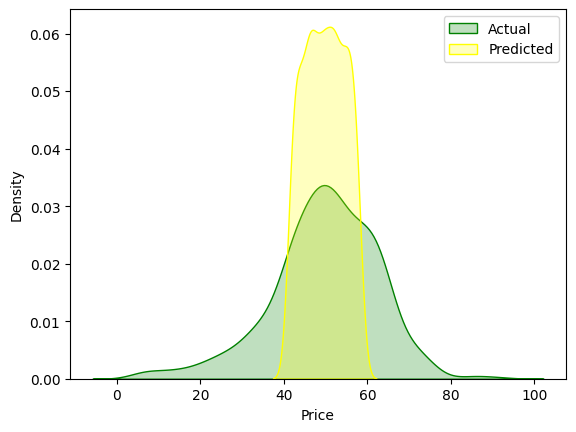

In [ ]:
sns.kdeplot(Y_test_reg, label='Actual', color='green', fill=True)
sns.kdeplot(predicted_reg, label='Predicted', color='yellow', fill=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

Как видим логистическая регрессия показала очень хороший результат даже на сырых данных и гораздо лучше  KNN.
Точность 0.7 показывает, что логистическая регрессия отлично подходит для классификации астероидов по опасности.

Линейная регрессия показала плохой результат. Из графика видно, что она может предсказывать цены в очень малом окне значений. При этом данные имеют четкий периодический характер, который нельзя описать прямой линией. Логистическая регрессия показывает только тренд роста цен из за инфляции

## 3.Улучшение бейз лайнов

### Классфикация

Для задачи классификации повторим действия из первой лабораторной, только предлагаю в этот раз оценить силу выбросов в данных, так как они имеют большее влияние на логистическую регрессию

In [ ]:
df_class['size'] = df_class[['est_diameter_min','est_diameter_max']].mean(axis=1)
df_class = df_class.drop(['est_diameter_min','est_diameter_max'],axis=1)

Смотрим на выбросы в магнитном поле объектов

<Axes: ylabel='absolute_magnitude'>

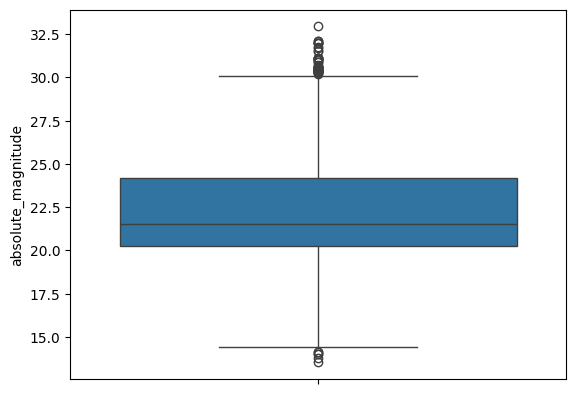

In [ ]:
sns.boxplot(df_class['absolute_magnitude'])

Смотрим на выбросы в размере объектов

<Axes: ylabel='size'>

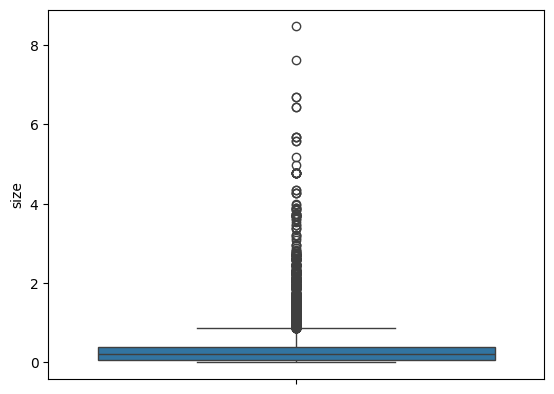

In [ ]:
sns.boxplot(df_class['size'])

Видим что данные очень не сбалансированные, выбросы имеют сильное влияние на выборку. Поэтому предлагаю произвести Z оценку датасета.
Это позволит нам нормализовать данные.

In [ ]:
from scipy import stats
from scipy.signal import savgol_filter

df_class = df_class[(np.abs(stats.zscore(df_class.drop(['hazardous'],axis=1))) < 3).all(axis=1)]

Посмотрим как изменились данные для размера астероидов и их магнитного поля

<Axes: ylabel='size'>

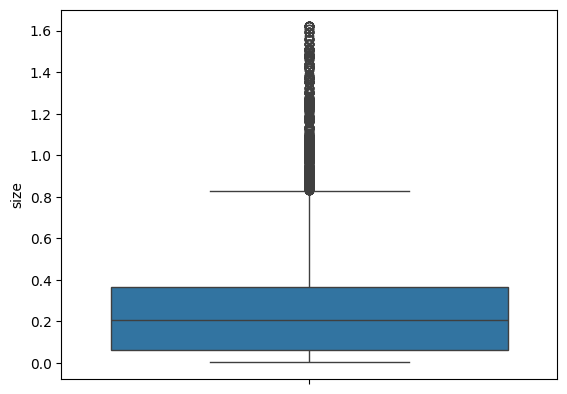

In [ ]:
sns.boxplot(df_class['size'])

<Axes: ylabel='absolute_magnitude'>

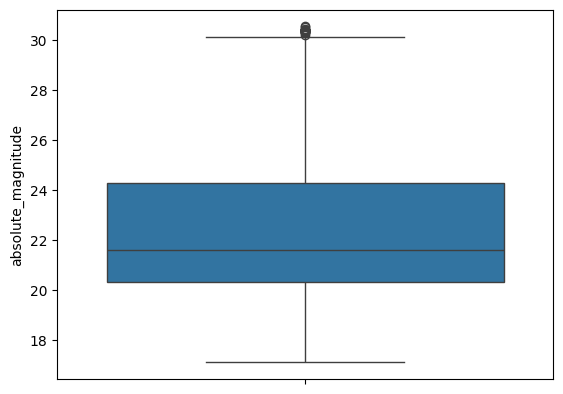

In [ ]:
sns.boxplot(df_class['absolute_magnitude'])

### Регрессия

В прошлой лабораторной было проведено достаточно хорошее улучшение бейзлайна регрессии, поэтому оно так же останется.
Но будет учитываться особенность линейной регрессии, которая особо чувствительна к выбросам. Поэтому будет проведена Z оценку чтобы нормализовать данные.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_reg = pd.read_csv('wind_vs_price.csv')
df_reg_price = pd.read_csv('da_price.csv')
df_reg = df_reg.drop(df_reg[df_reg.fecha > "2019-01-01"].index)
df_reg = df_reg.drop(['AVG(dp.precio)', 'MIN(dp.precio)', 'MAX(dp.precio)'],axis=1)
df_reg = pd.merge(df_reg_price, df_reg, on='fecha', how='left')
df_reg = df_reg.dropna(how='any',axis=0)
df_reg['datetime_utc'] = pd.to_datetime(df_reg['datetime_utc'])
df_reg = df_reg.drop(['fecha', 'sistema', 'bandera', 'fecha_actualizacion'],axis=1)

# Новый параметр дня недели
df_reg['date_of_week'] = df_reg['datetime_utc'].dt.day_name().astype('category').cat.codes

# Новый параметр месяца
df_reg['month'] = df_reg['datetime_utc'].dt.month.astype('category').cat.codes
df_reg['datetime_utc'] = df_reg['datetime_utc'].astype(int)

# Объединение параметров ветра
df_reg['wind'] = df_reg[['AVG(wd.vel_km_h)','MAX(wd.racha_max_km_h)']].mean(axis=1)
df_reg = df_reg.drop(['AVG(wd.vel_km_h)','MAX(wd.racha_max_km_h)'],axis=1)

Оценим данные на сбалансированность значений скорости ветра

<Axes: ylabel='wind'>

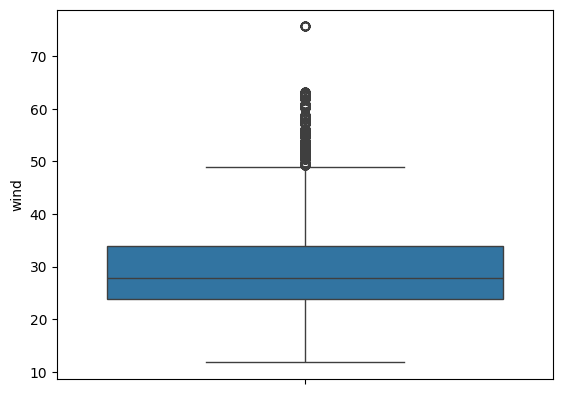

In [ ]:
sns.boxplot(df_reg['wind'])

Оценим данные на сбалансированность значений цены

<Axes: ylabel='precio'>

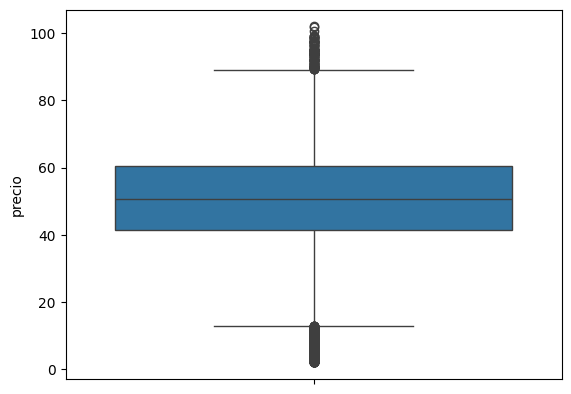

In [ ]:
sns.boxplot(df_reg['precio'])

Нормализуем рассмотренные две колонки через Z оценку. Это должно повлиять на качество предсказания

In [ ]:
df_reg = df_reg[(np.abs(stats.zscore(df_reg[['precio', 'wind']])) < 3).all(axis=1)]

<Axes: ylabel='wind'>

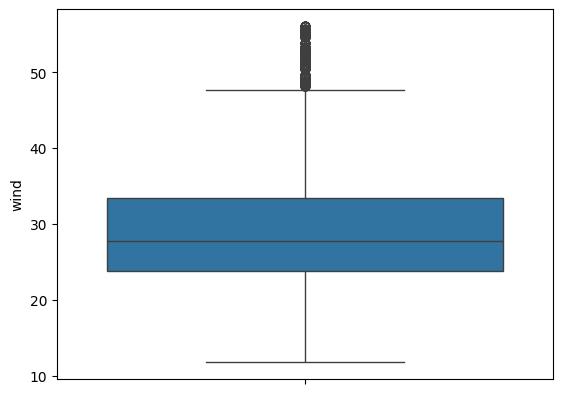

In [ ]:
sns.boxplot(df_reg['wind'])

Теперь данные должны быть выстроены в более прямую линию, что хорошо для линейной регрессии

## Итоговые гипотезы

- Классификация
  - Объединение параметров размера астероида
  - Z-оценка
- Регрессия
  - Объединение таблицы цены и силы ветра
  - Объединение параметров среднего и максимального силы ветра
  - Z-оценка
  - MinMaxScaling

In [ ]:
# Классификация
Y_class = df_class['hazardous'].astype(int)
scaler = MinMaxScaler()
X_class = df_class.drop(['hazardous'],axis=1)
X_reg = scaler.fit_transform(X_class)
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_reg,Y_class,random_state=24314,test_size=0.5, shuffle = True)

# Регрессия
Y_reg = df_reg['precio']
scaler = MinMaxScaler()
X_reg = df_reg.drop(['precio'],axis=1)
X_reg = scaler.fit_transform(X_reg)
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_reg,Y_reg,random_state=24314,test_size=0.5, shuffle = True)

Обучаем модели

In [ ]:
line_reg = LinearRegression()
line_reg.fit(X_train_reg, Y_train_reg)

log_reg = LogisticRegression()
log_reg.fit(X_train_class, Y_train_class)

LogisticRegression()

### Оценим классификацию

In [ ]:
predicted_class = log_reg.predict(X_test_class)
print("Classification accuracy score = ",metrics.accuracy_score(Y_test_class,predicted_class))
print("Classification CM score\n================\n",metrics.confusion_matrix(Y_test_class,predicted_class))
print("================\nClassification F1 score = ",metrics.f1_score(Y_test_class,predicted_class, average='weighted'))

Classification accuracy score =  0.870314318975553
Classification CM score
 [[3408  951]
 [ 163 4068]]
Classification F1 score =  0.8693948284471157


Нам удалось знаительно повысить точность классификации

### Оценка предсказания

In [ ]:
predicted_reg = line_reg.predict(X_test_reg)
print("MSE score = ",metrics.mean_squared_error(Y_test_reg, predicted_reg))
print("R2 score = ",metrics.r2_score(Y_test_reg, predicted_reg))

MSE score =  127.03112008934916
R2 score =  0.22367079384890387


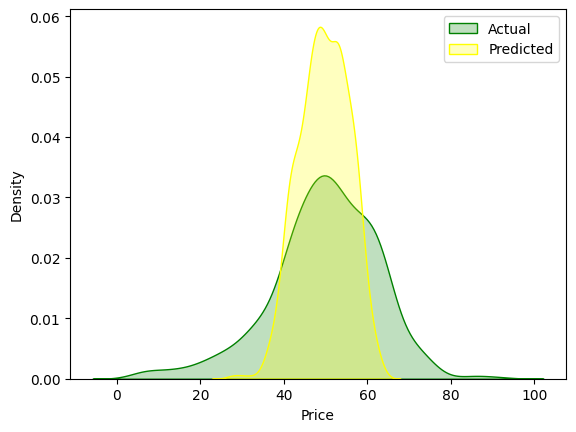

In [ ]:
sns.kdeplot(Y_test_reg, label='Actual', color='green', fill=True)
sns.kdeplot(predicted_reg, label='Predicted', color='yellow', fill=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

Линейная регрессия стала в разы лучше работать, когда мы провели нормализацию данных. Метрика R2 стала показывать результат на 10% лучше чем на сырых данных

# Имплементация алгоритма машинного обучения

Линейная регрессия

In [ ]:
class MyLinearRegression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

        self.intercept_ = theta[0]
        self.coef_ = theta[1:]

    def predict(self, X):
        return np.dot(X, self.coef_) + self.intercept_


Логистическая регрессия

In [ ]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.1, num_iterations=10000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.theta = np.zeros((self.n, 1))
        self.bias = 0

        y = y.reshape(self.m, 1)

        for i in range(self.num_iterations):
            z = np.dot(X, self.theta) + self.bias
            h = self.sigmoid(z)
            dz = h - y
            dw = np.dot(X.T, dz) / self.m
            db = np.sum(dz) / self.m
            self.theta -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        z = np.dot(X, self.theta) + self.bias
        h = self.sigmoid(z)
        return h >= 0.5


### Обучение и оценка модели

In [ ]:
df_class = pd.read_csv('neo_v2.csv')
df_reg = pd.read_csv('wind_vs_price.csv')

df_class = df_class.drop(['orbiting_body','sentry_object', 'name', 'id'],axis=1)
df_class = df_class.sort_values('hazardous', ascending=False).head(2*df_class['hazardous'].value_counts().get(True, 0))

df_reg = df_reg.drop(df_reg[df_reg.fecha > "2019-01-01"].index)
df_reg['time'] = pd.to_datetime(df_reg['fecha']).astype(int)
df_reg = df_reg.drop(['fecha', 'MIN(dp.precio)', 'MAX(dp.precio)'], axis = 1)

# Классификация
Y_class = df_class['hazardous'].astype(int)
X_class = df_class.drop(['hazardous'],axis=1)
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_class,Y_class,random_state=24,test_size=0.5, shuffle = True)

# Регрессия
Y_reg = df_reg['AVG(dp.precio)']
X_reg = df_reg.drop(['AVG(dp.precio)'],axis=1)
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_reg,Y_reg,random_state=24314,test_size=0.5, shuffle = True)

Обучение моделей

In [ ]:
import warnings
warnings.filterwarnings("ignore")

line_reg = MyLinearRegression()
line_reg.fit(X_train_reg, Y_train_reg)

log_reg = MyLogisticRegression()
log_reg.fit(X_train_class.to_numpy(), Y_train_class.to_numpy())

Оценка логистической регрессии

In [ ]:
predicted_class = log_reg.predict(X_test_class.to_numpy())
print("Classification accuracy score = ",metrics.accuracy_score(Y_test_class.to_numpy(),predicted_class))
print("Classification F1 score = ",metrics.f1_score(Y_test_class.to_numpy(),predicted_class, average='weighted'))

Classification accuracy score =  0.49536199095022626
Classification F1 score =  0.33153542978703976


Оценка линейной регрессии

In [ ]:
predicted_reg = line_reg.predict(X_test_reg)
print("MSE score = ",metrics.mean_squared_error(Y_test_reg, predicted_reg))
print("R2 score = ",metrics.r2_score(Y_test_reg, predicted_reg))

MSE score =  127.03112008934916
R2 score =  0.22367079384890387


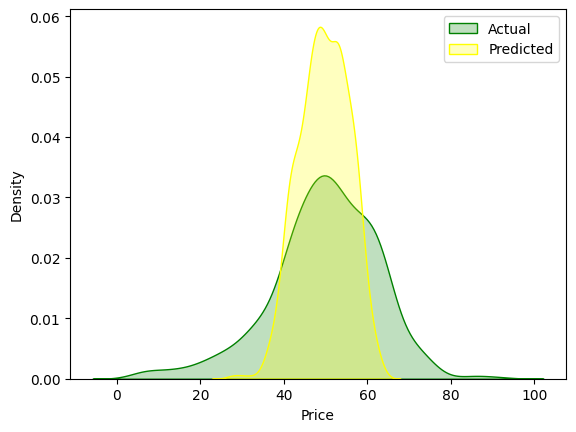

In [ ]:
sns.kdeplot(Y_test_reg, label='Actual', color='green', fill=True)
sns.kdeplot(predicted_reg, label='Predicted', color='yellow', fill=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

# Применяем улучшенный бейзлайн для собственных моделей

Бейзлайн классификации

In [ ]:
df_class['size'] = df_class[['est_diameter_min','est_diameter_max']].mean(axis=1)
df_class = df_class.drop(['est_diameter_min','est_diameter_max'],axis=1)
df_class = df_class[(np.abs(stats.zscore(df_class.drop(['hazardous'],axis=1))) < 3).all(axis=1)]

Бейзлайн регрессии

In [ ]:
df_reg = pd.read_csv('wind_vs_price.csv')
df_reg_price = pd.read_csv('da_price.csv')

df_reg = df_reg.drop(df_reg[df_reg.fecha > "2019-01-01"].index)
df_reg = df_reg.drop(['AVG(dp.precio)', 'MIN(dp.precio)', 'MAX(dp.precio)'],axis=1)
df_reg = pd.merge(df_reg_price, df_reg, on='fecha', how='left')
df_reg = df_reg.dropna(how='any',axis=0)
df_reg['datetime_utc'] = pd.to_datetime(df_reg['datetime_utc'])
df_reg = df_reg.drop(['fecha', 'sistema', 'bandera', 'fecha_actualizacion'],axis=1)

# Новый параметр дня недели
df_reg['date_of_week'] = df_reg['datetime_utc'].dt.day_name().astype('category').cat.codes

# Новый параметр месяца
df_reg['month'] = df_reg['datetime_utc'].dt.month.astype('category').cat.codes
df_reg['datetime_utc'] = df_reg['datetime_utc'].astype(int)

# Объединение параметров ветра
df_reg['wind'] = df_reg[['AVG(wd.vel_km_h)','MAX(wd.racha_max_km_h)']].mean(axis=1)
df_reg = df_reg.drop(['AVG(wd.vel_km_h)','MAX(wd.racha_max_km_h)'],axis=1)
df_reg = df_reg[(np.abs(stats.zscore(df_reg[['precio', 'wind']])) < 3).all(axis=1)]

## Обучение своих моделей на улучшенных бейзалйнах

Готовим датасеты

In [ ]:
# Классификация
Y_class = df_class['hazardous'].astype(int)
scaler = MinMaxScaler()
X_class = df_class.drop(['hazardous'],axis=1)
X_reg = scaler.fit_transform(X_class)
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_reg,Y_class,random_state=24314,test_size=0.5, shuffle = True)

# Регрессия
Y_reg = df_reg['precio']
scaler = MinMaxScaler()
X_reg = df_reg.drop(['precio'],axis=1)
X_reg = scaler.fit_transform(X_reg)
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_reg,Y_reg,random_state=24314,test_size=0.5, shuffle = True)

Обучение моделей

In [ ]:
line_reg = MyLinearRegression()
line_reg.fit(X_train_reg, Y_train_reg)

log_reg = MyLogisticRegression()
log_reg.fit(X_train_class, Y_train_class.to_numpy())

Оценка логистической регресии

In [ ]:
predicted_class = log_reg.predict(X_test_class)
print("Classification accuracy score = ",metrics.accuracy_score(Y_test_class.to_numpy(),predicted_class))
print("Classification F1 score = ",metrics.f1_score(Y_test_class.to_numpy(),predicted_class, average='weighted'))

Classification accuracy score =  0.8519208381839348
Classification F1 score =  0.8515676603816738


Оценка линейной регрессии

In [ ]:
predicted_reg = line_reg.predict(X_test_reg)
print("MSE score = ",metrics.mean_squared_error(Y_test_reg, predicted_reg))
print("R2 score = ",metrics.r2_score(Y_test_reg, predicted_reg))

MSE score =  143.70189689847734
R2 score =  0.26053871575377907


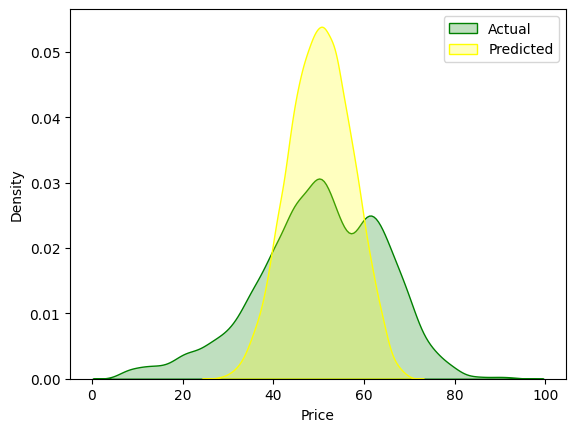

In [ ]:
sns.kdeplot(Y_test_reg, label='Actual', color='green', fill=True)
sns.kdeplot(predicted_reg, label='Predicted', color='yellow', fill=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

Как видим, на обоих моделях улучшенный бейз лайн сказался незначительно, но в лучшую сторону. Лучше всего улучшенный бейзлайн отразился на классификации

# Сравнительные выводы

Соберём все лучшие результаты и метрики внутри одной таблицы чтобы провести итоговое сравнение всех моделей

|Модель|Метрики обычного бейзлайна|Метрики улучшенного бейзлайна|
|-|-|-|
|Логистическая регрессия|max_acc = 0.776 max_F1 = 0.776|max_acc = 0.87 max_F1 = 0.869|
|Моя логистическая регрессия|max_acc = 0.49 max_F1 = 0.33|max_acc = 0.85 max_F1 = 0.85|
|Линейная регрессия|min_MSE = 140.029 max_R2 = 0.144|min_MSE = 127.03 max_R2 = 0.22|
|Моя линейная регрессия|min_MSE = 127.03 max_R2 = 0.22|min_MSE = 143.7 max_R2 = 0.26|



В ходе лабораторной работы получилось добиться почти во всех случаях улучшения качества предсказания и классификации для моделей за счет улучшенного бейзлайна. Во всех случаях библиотечная реализация моделей оказалась немного или сильно лучше по сравнению с моей реализацией.